# Logistic Regression Model for S&P 500 Prediction

This notebook uses the combined S&P 500 dataset (2020-2025) created from the 6 CSV files to train a Logistic Regression model for market direction prediction.

The model will predict whether the S&P 500 will go up (1) or down (0) based on technical indicators.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta.trend import SMAIndicator, EMAIndicator
from ta.momentum import RSIIndicator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
# 1. Load S&P 500 data from combined CSV
df = pd.read_csv("../Dataset/SP500_combined_2020-2025.csv")

# Convert Date column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Sort by date in chronological order (oldest to newest)
df = df.sort_index()

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print("\nColumns available:")
print(df.columns.tolist())
print("\nFirst few rows (oldest dates):")
print(df.head())
print("\nLast few rows (newest dates):")
print(df.tail())

# Verify chronological order
print(f"\n✅ Data is sorted chronologically: {df.index.is_monotonic_increasing}")
print(f"Total trading days: {len(df)}")

Dataset shape: (1398, 5)
Date range: 2020-01-02 00:00:00 to 2025-07-25 00:00:00

Columns available:
['Open', 'High', 'Low', 'Close', 'source_file']

First few rows (oldest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2020-01-02  3,244.67  3,258.14  3,235.53  3,257.85  1_01012020 to 12312020.csv
2020-01-03  3,226.36  3,246.15  3,222.34  3,234.85  1_01012020 to 12312020.csv
2020-01-06  3,217.55  3,246.84  3,214.64  3,246.28  1_01012020 to 12312020.csv
2020-01-07  3,241.86  3,244.91  3,232.43  3,237.18  1_01012020 to 12312020.csv
2020-01-08  3,238.59  3,267.07  3,236.67  3,253.05  1_01012020 to 12312020.csv

Last few rows (newest dates):
                Open      High       Low     Close                 source_file
Date                                                                          
2025-07-21  6,304.74  6,336.08  6,303.79  6,305.60  6_01012025 to 25072025.csv

In [3]:
# 2. Clean and convert numeric columns
# Remove commas and convert to float for all price columns
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

for col in price_columns:
    if col in df.columns:
        # Convert to string first, remove commas, then convert to float
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Convert Volume to numeric (remove commas if present)
if 'Volume' in df.columns:
    df['Volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)

print("Data types after conversion:")
print(df.dtypes)
print("\nPrice data sample:")
print(df[['Open', 'High', 'Low', 'Close']].head())

Data types after conversion:
Open           float64
High           float64
Low            float64
Close          float64
source_file     object
dtype: object

Price data sample:
               Open     High      Low    Close
Date                                          
2020-01-02  3244.67  3258.14  3235.53  3257.85
2020-01-03  3226.36  3246.15  3222.34  3234.85
2020-01-06  3217.55  3246.84  3214.64  3246.28
2020-01-07  3241.86  3244.91  3232.43  3237.18
2020-01-08  3238.59  3267.07  3236.67  3253.05


In [4]:
# 3. Create technical indicators
df["SMA_10"] = SMAIndicator(close=df["Close"], window=10).sma_indicator()
df["EMA_10"] = EMAIndicator(close=df["Close"], window=10).ema_indicator()
df["RSI"] = RSIIndicator(close=df["Close"], window=14).rsi()

In [5]:
# 4. Create target variable (market direction)
# 1 if price goes up next day, 0 if it goes down
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

print("Target variable created:")
print(f"Up days (1): {(df['Target'] == 1).sum()}")
print(f"Down days (0): {(df['Target'] == 0).sum()}")
print(f"Target distribution: {df['Target'].value_counts().sort_index()}")

Target variable created:
Up days (1): 757
Down days (0): 641
Target distribution: Target
0    641
1    757
Name: count, dtype: int64


In [6]:
# 5. Drop missing values
df.dropna(inplace=True)

In [7]:
# 6. Prepare data
features = ["SMA_10", "EMA_10", "RSI"]
X = df[features]
y = df["Target"]

# Check data quality
print("=== Data Quality Check ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts().sort_index())
print(f"Class balance: {y.value_counts(normalize=True).sort_index()}")

print(f"\nFeature statistics:")
print(X.describe())

print(f"\nMissing values:")
print(X.isnull().sum())
print(f"Target missing values: {y.isnull().sum()}")

=== Data Quality Check ===
Features shape: (1385, 3)
Target shape: (1385,)

Target distribution:
Target
0    636
1    749
Name: count, dtype: int64
Class balance: Target
0    0.459206
1    0.540794
Name: proportion, dtype: float64

Feature statistics:
            SMA_10       EMA_10          RSI
count  1385.000000  1385.000000  1385.000000
mean   4422.007148  4422.036319    55.230069
std     869.553979   868.624395    11.472751
min    2435.956000  2486.247281    18.106629
25%    3875.432000  3877.526116    46.697980
50%    4331.183000  4329.281135    56.984853
75%    5048.218000  5065.129316    63.985993
max    6309.629000  6318.533367    82.900322

Missing values:
SMA_10    0
EMA_10    0
RSI       0
dtype: int64
Target missing values: 0


In [8]:
# 7. Train/test split (keep temporal order)
X_train, X_test = X.iloc[:-100], X.iloc[-100:]
y_train, y_test = y.iloc[:-100], y.iloc[-100:]

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts().sort_index())
print(f"Test set class distribution:")
print(y_test.value_counts().sort_index())

# Feature scaling for logistic regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled successfully!")
print(f"Training features range after scaling:")
print(f"Min: {X_train_scaled.min(axis=0)}")
print(f"Max: {X_train_scaled.max(axis=0)}")

Training set: 1285 samples
Test set: 100 samples

Training set class distribution:
Target
0    596
1    689
Name: count, dtype: int64
Test set class distribution:
Target
0    40
1    60
Name: count, dtype: int64

Features scaled successfully!
Training features range after scaling:
Min: [-2.33359717 -2.27432571 -3.30095104]
Max: [2.20741158 2.21846945 2.45716044]

Features scaled successfully!
Training features range after scaling:
Min: [-2.33359717 -2.27432571 -3.30095104]
Max: [2.20741158 2.21846945 2.45716044]


In [9]:
# 8. Train Logistic Regression
# Use balanced class weights to handle class imbalance
model = LogisticRegression(
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,           # Ensure convergence
    solver='liblinear'       # Good for small datasets
)

model.fit(X_train_scaled, y_train)

print("✅ Logistic Regression model trained successfully!")
print(f"Model coefficients: {model.coef_[0]}")
print(f"Model intercept: {model.intercept_[0]}")
print(f"Feature importance (absolute coefficients):")
for feature, coef in zip(features, np.abs(model.coef_[0])):
    print(f"  {feature}: {coef:.4f}")

✅ Logistic Regression model trained successfully!
Model coefficients: [ 0.06456177 -0.06500356  0.00423412]
Model intercept: 1.515772460704891e-06
Feature importance (absolute coefficients):
  SMA_10: 0.0646
  EMA_10: 0.0650
  RSI: 0.0042


In [10]:
# 9. Predict
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

print("✅ Predictions completed!")
print(f"Predictions distribution:")
print(f"  Predicted down (0): {(y_pred == 0).sum()}")
print(f"  Predicted up (1): {(y_pred == 1).sum()}")

print(f"\nProbability statistics:")
print(f"  Mean probability for class 0: {y_pred_proba[:, 0].mean():.4f}")
print(f"  Mean probability for class 1: {y_pred_proba[:, 1].mean():.4f}")
print(f"  Min probability for class 1: {y_pred_proba[:, 1].min():.4f}")
print(f"  Max probability for class 1: {y_pred_proba[:, 1].max():.4f}")

✅ Predictions completed!
Predictions distribution:
  Predicted down (0): 45
  Predicted up (1): 55

Probability statistics:
  Mean probability for class 0: 0.5003
  Mean probability for class 1: 0.4997
  Min probability for class 1: 0.4968
  Max probability for class 1: 0.5015


In [11]:
# 10. Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("=== Model Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba[:, 1]):.4f}")

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, zero_division=0))

=== Model Performance ===
Accuracy: 0.5300
Precision: 0.6182
Recall: 0.5667
F1-Score: 0.5913
ROC-AUC: 0.5104

=== Confusion Matrix ===
[[19 21]
 [26 34]]

True Negatives: 19
False Positives: 21
False Negatives: 26
True Positives: 34

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.42      0.47      0.45        40
           1       0.62      0.57      0.59        60

    accuracy                           0.53       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.54      0.53      0.53       100



In [12]:
# 11. Import libraries for visualizations
from sklearn.metrics import roc_curve
import seaborn as sns

print("✅ Libraries imported for visualizations")

✅ Libraries imported for visualizations


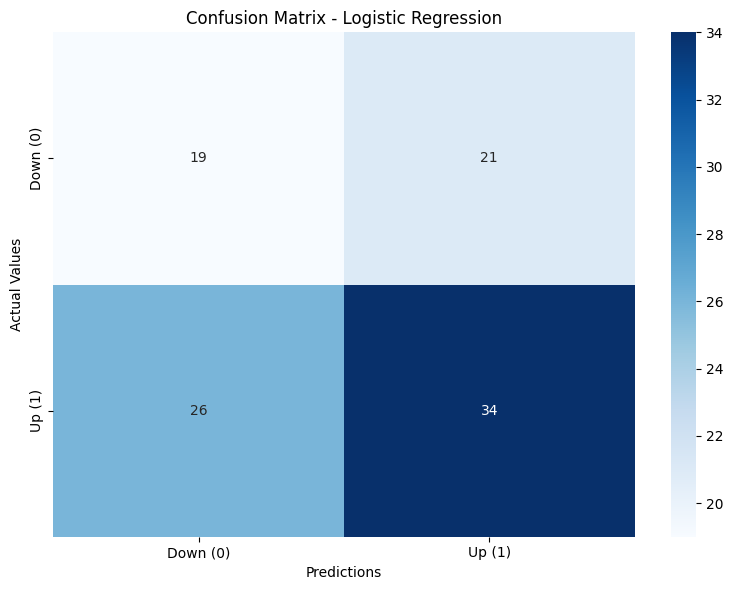

In [13]:
# 12. Visualization 1: Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'], yticklabels=['Down (0)', 'Up (1)'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual Values')
plt.xlabel('Predictions')
plt.tight_layout()
plt.show()

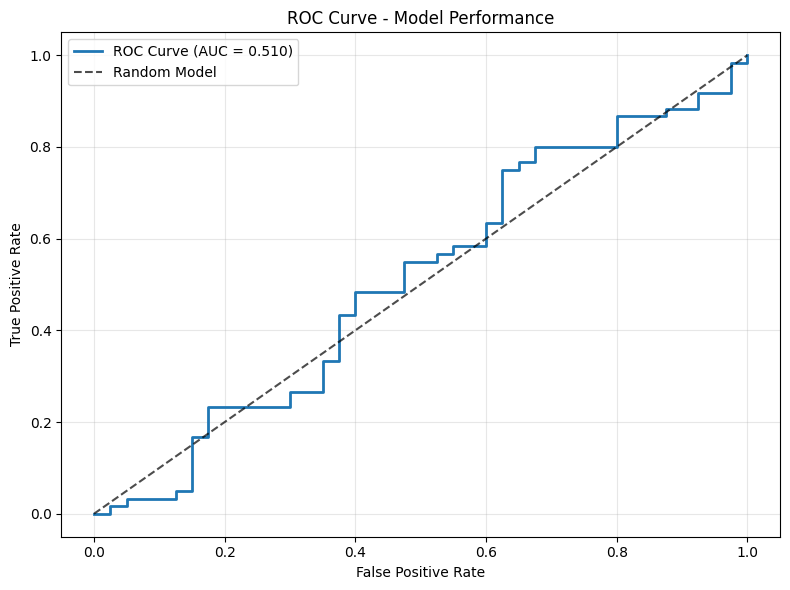

AUC Score: 0.5104
⚠️ Moderate performance


In [14]:
# 13. Visualization 2: ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Model', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")
if auc_score > 0.7:
    print("✅ Good model performance")
elif auc_score > 0.5:
    print("⚠️ Moderate performance")
else:
    print("❌ Poor performance")

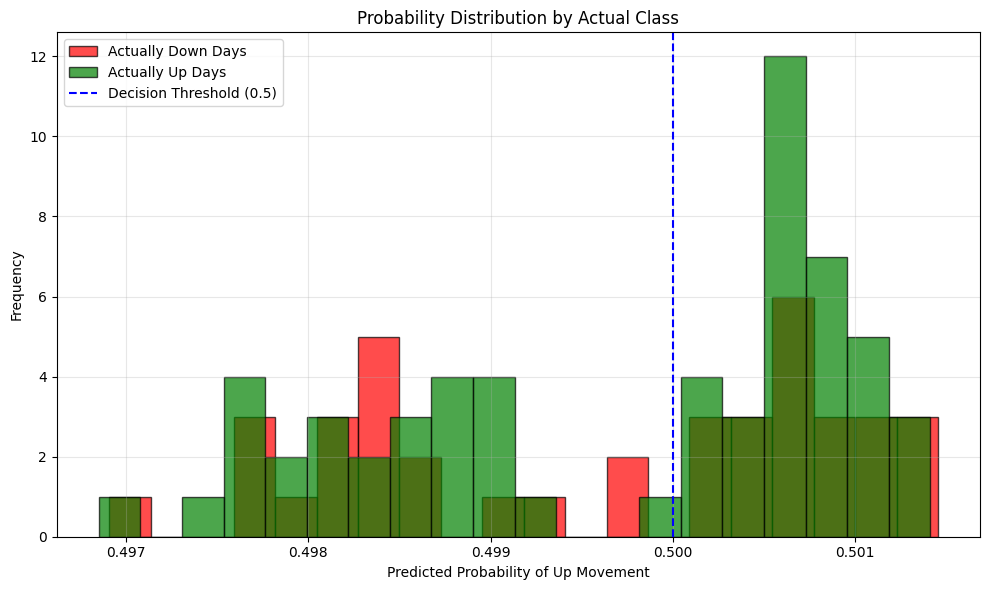

Average probability for down days: 0.500
Average probability for up days: 0.500
Class separation: 0.000


In [15]:
# 14. Visualization 3: Probability Distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y_test == 0, 1], alpha=0.7, label='Actually Down Days', 
         bins=20, color='red', edgecolor='black')
plt.hist(y_pred_proba[y_test == 1, 1], alpha=0.7, label='Actually Up Days', 
         bins=20, color='green', edgecolor='black')
plt.axvline(x=0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)')
plt.xlabel('Predicted Probability of Up Movement')
plt.ylabel('Frequency')
plt.title('Probability Distribution by Actual Class')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Class separation statistics
prob_down_mean = y_pred_proba[y_test == 0, 1].mean()
prob_up_mean = y_pred_proba[y_test == 1, 1].mean()
print(f"Average probability for down days: {prob_down_mean:.3f}")
print(f"Average probability for up days: {prob_up_mean:.3f}")
print(f"Class separation: {abs(prob_up_mean - prob_down_mean):.3f}")

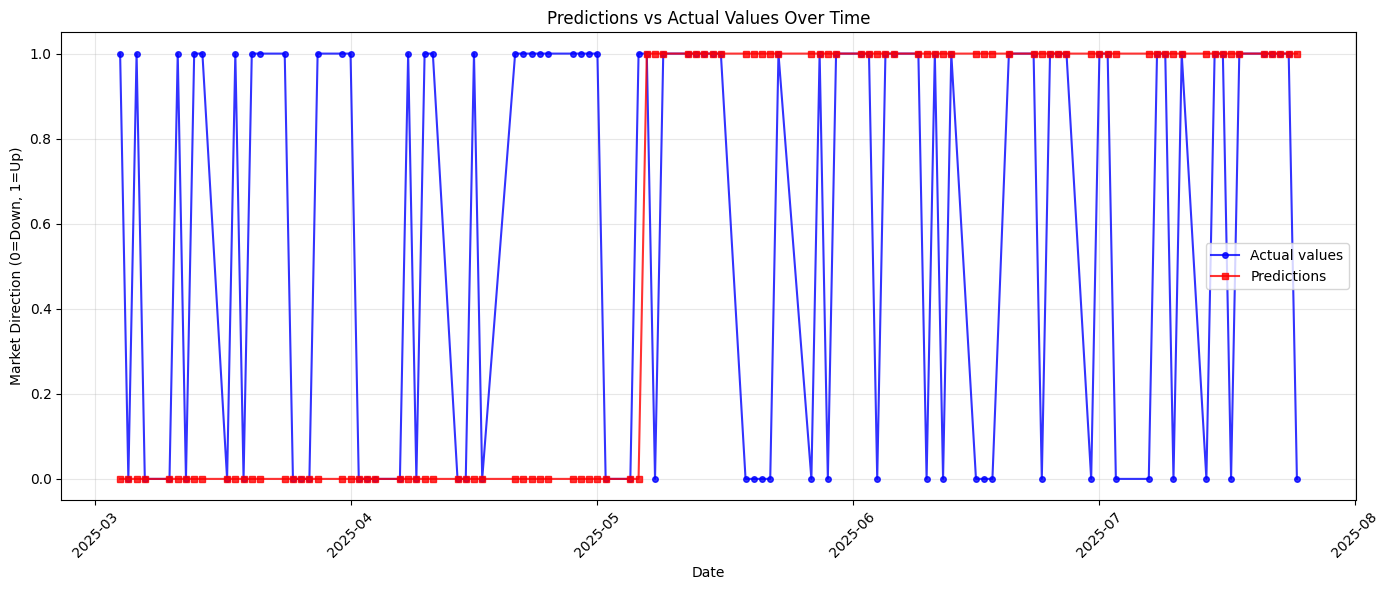

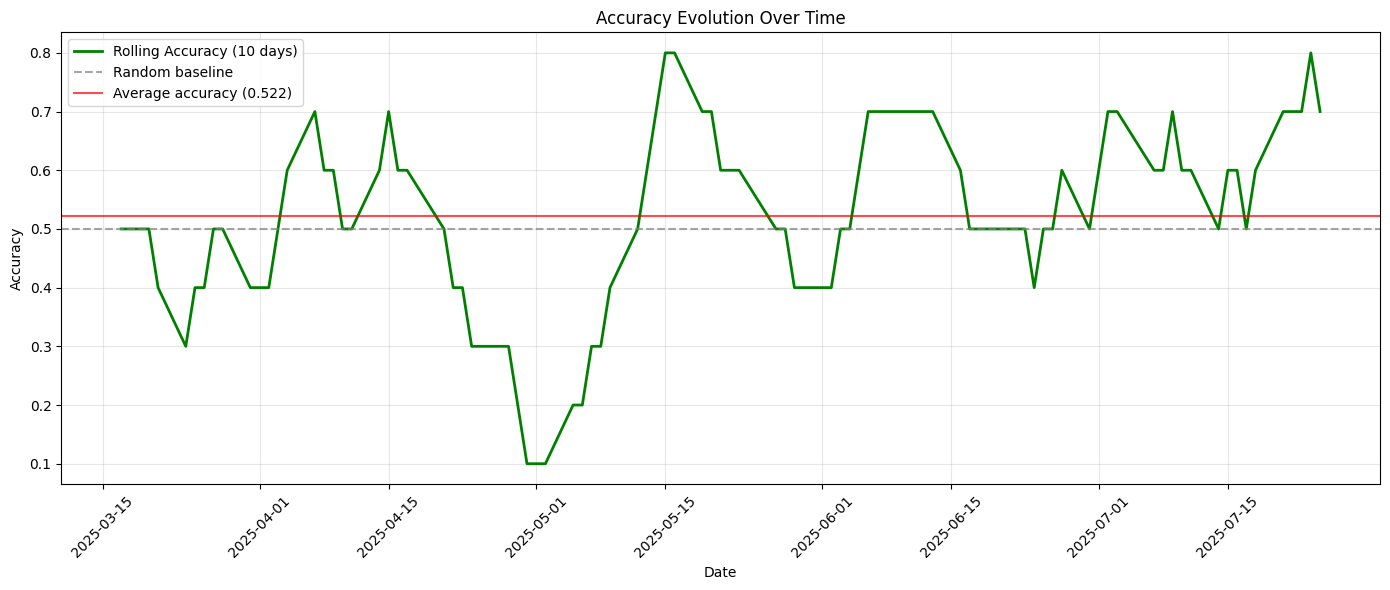

In [16]:
# 15. Visualization 4: Time Series - Predictions vs Reality
plt.figure(figsize=(14, 6))
dates = y_test.index

plt.plot(dates, y_test.values, 'o-', label='Actual values', alpha=0.8, 
         markersize=4, color='blue', linewidth=1.5)
plt.plot(dates, y_pred, 's-', label='Predictions', alpha=0.8, 
         markersize=4, color='red', linewidth=1.5)

plt.title('Predictions vs Actual Values Over Time')
plt.xlabel('Date')
plt.ylabel('Market Direction (0=Down, 1=Up)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Performance analysis over time
correct_preds = (y_pred == y_test)
accuracy_timeline = correct_preds.rolling(window=10).mean()

plt.figure(figsize=(14, 6))
plt.plot(dates, accuracy_timeline, label='Rolling Accuracy (10 days)', 
         color='green', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Random baseline')
plt.axhline(y=accuracy_timeline.mean(), color='red', linestyle='-', 
            alpha=0.7, label=f'Average accuracy ({accuracy_timeline.mean():.3f})')
plt.title('Accuracy Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

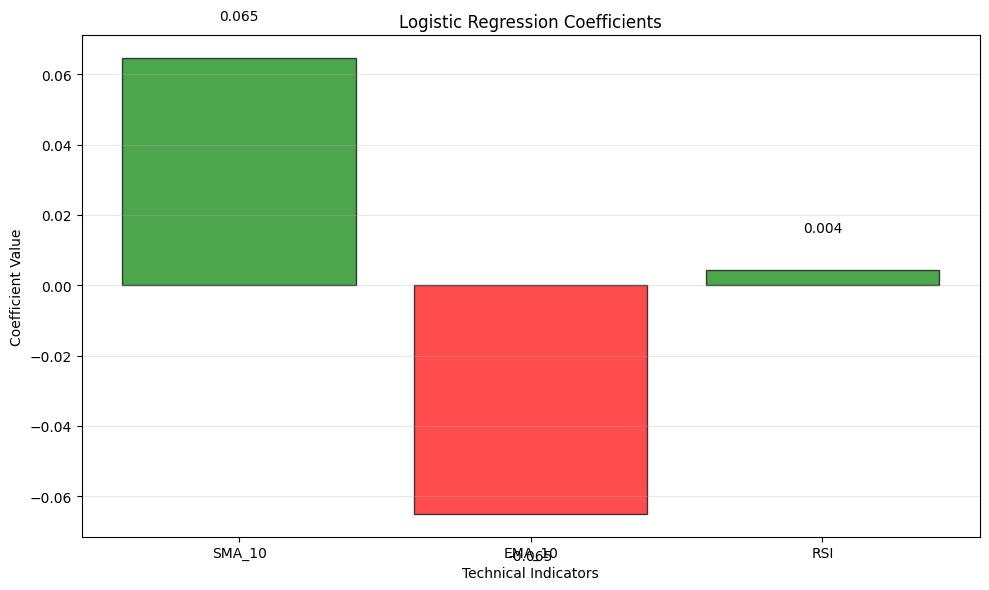

=== Coefficient Interpretation ===
SMA_10: 0.0646 (positive influence, weak intensity)
EMA_10: -0.0650 (negative influence, weak intensity)
RSI: 0.0042 (positive influence, weak intensity)

🔍 Most influential indicator: EMA_10


In [17]:
# 16. Visualization 5: Model Coefficients
plt.figure(figsize=(10, 6))
coefficients = model.coef_[0]
colors = ['red' if c < 0 else 'green' for c in coefficients]

bars = plt.bar(features, coefficients, color=colors, alpha=0.7, edgecolor='black')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Technical Indicators')
plt.ylabel('Coefficient Value')
plt.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar, coef in zip(bars, coefficients):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.01),
             f'{coef:.3f}', ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

# Coefficient interpretation
print("=== Coefficient Interpretation ===")
for feature, coef in zip(features, coefficients):
    impact = "positive" if coef > 0 else "negative"
    strength = "strong" if abs(coef) > 0.5 else "moderate" if abs(coef) > 0.2 else "weak"
    print(f"{feature}: {coef:.4f} ({impact} influence, {strength} intensity)")
    
most_important = features[np.argmax(np.abs(coefficients))]
print(f"\n🔍 Most influential indicator: {most_important}")

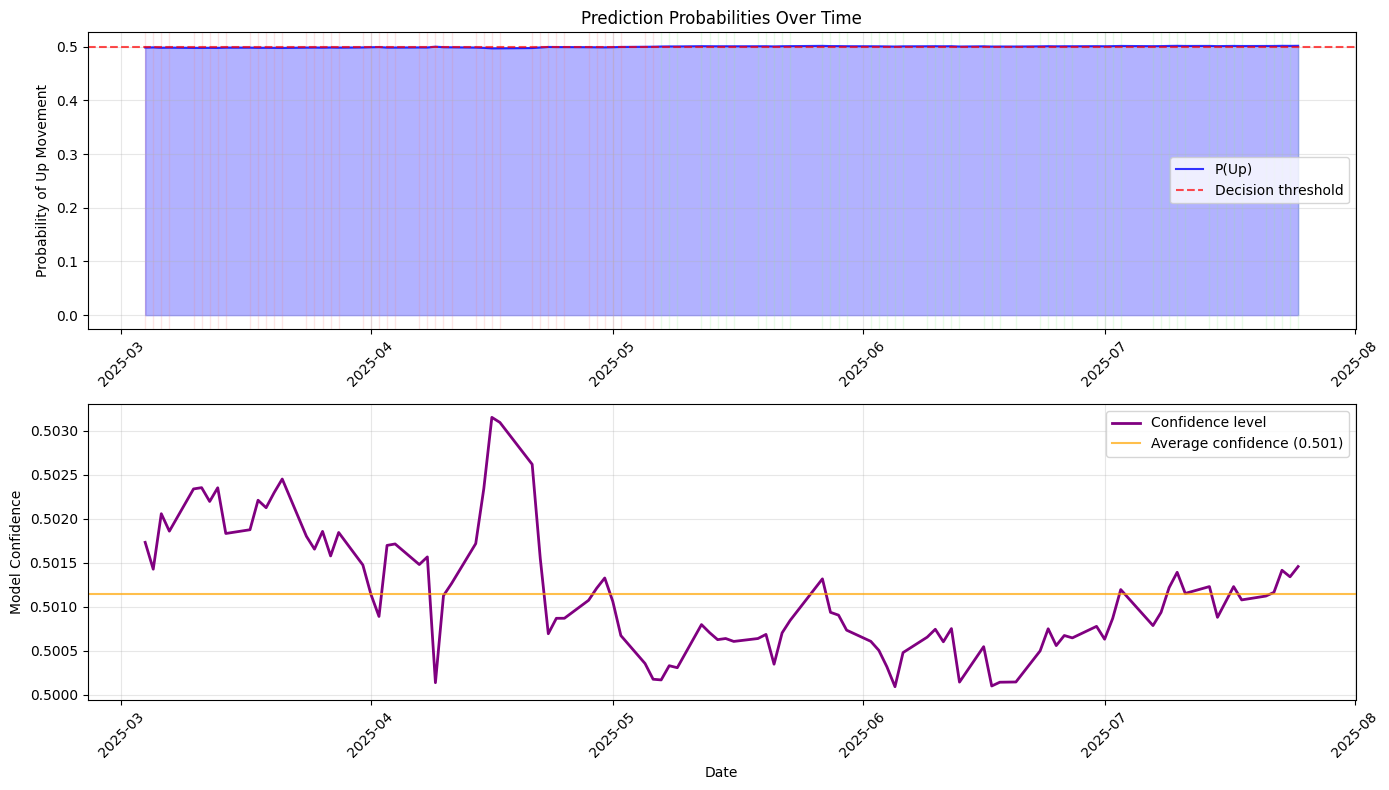

=== Confidence Analysis ===
High confidence predictions (>70%): 0/100 (0.0%)
Average confidence: 0.501
Accuracy on high confidence predictions: nan


In [18]:
# 17. Visualization 6: Prediction Probabilities Over Time
plt.figure(figsize=(14, 8))

# Main plot
plt.subplot(2, 1, 1)
dates = y_test.index
prob_up = y_pred_proba[:, 1]

plt.plot(dates, prob_up, label='P(Up)', alpha=0.8, color='blue', linewidth=1.5)
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision threshold', alpha=0.7)
plt.fill_between(dates, 0, prob_up, alpha=0.3, color='blue')

# Color background according to predictions
for i in range(len(dates)):
    color = 'lightgreen' if y_pred[i] == 1 else 'lightcoral'
    alpha = 0.2
    plt.axvspan(dates[i], dates[i], alpha=alpha, color=color)

plt.title('Prediction Probabilities Over Time')
plt.ylabel('Probability of Up Movement')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Confidence plot
plt.subplot(2, 1, 2)
confidence = np.maximum(prob_up, 1 - prob_up)  # Distance to 0.5 threshold
plt.plot(dates, confidence, label='Confidence level', color='purple', linewidth=2)
plt.axhline(y=confidence.mean(), color='orange', linestyle='-', 
            label=f'Average confidence ({confidence.mean():.3f})', alpha=0.7)
plt.ylabel('Model Confidence')
plt.xlabel('Date')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confidence statistics
high_confidence = confidence > 0.7
print(f"=== Confidence Analysis ===")
print(f"High confidence predictions (>70%): {high_confidence.sum()}/{len(confidence)} ({high_confidence.mean()*100:.1f}%)")
print(f"Average confidence: {confidence.mean():.3f}")
print(f"Accuracy on high confidence predictions: {((y_pred == y_test)[high_confidence]).mean():.3f}")

In [19]:
# 18. Model Summary and Trading Simulation
print("="*60)
print("🎯 LOGISTIC REGRESSION MODEL SUMMARY")
print("="*60)

print(f"\n📊 Model Configuration:")
print(f"   • Type: Logistic Regression with balanced class weights")
print(f"   • Indicators used: {', '.join(features)}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test)}")
print(f"   • Test period: {y_test.index.min().strftime('%m/%d/%Y')} to {y_test.index.max().strftime('%m/%d/%Y')}")

print(f"\n📈 Model Performance:")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"   • Accuracy: {accuracy:.1%}")
print(f"   • Precision (class 1): {precision:.1%}")
print(f"   • Recall: {recall:.1%}")
print(f"   • F1-Score: {f1:.3f}")
print(f"   • AUC-ROC: {auc:.3f}")

# Simple trading simulation
correct_predictions = (y_pred == y_test).sum()
tp = ((y_pred == 1) & (y_test == 1)).sum()  # True Positives
tn = ((y_pred == 0) & (y_test == 0)).sum()  # True Negatives
fp = ((y_pred == 1) & (y_test == 0)).sum()  # False Positives
fn = ((y_pred == 0) & (y_test == 1)).sum()  # False Negatives

print(f"\n💰 Trading Simulation:")
print(f"   • Correct predictions: {correct_predictions}/{len(y_test)} ({accuracy:.1%})")
print(f"   • Success - Predicted UP and realized: {tp} days")
print(f"   • Success - Predicted DOWN and realized: {tn} days")
print(f"   • Error - False alarms (predicted up): {fp} days")
print(f"   • Error - Missed opportunities: {fn} days")

# Performance compared to random
random_accuracy = max(y_test.value_counts(normalize=True))
improvement = (accuracy - random_accuracy) / random_accuracy * 100

print(f"\n🎲 Comparison:")
print(f"   • Random strategy: {random_accuracy:.1%}")
print(f"   • Our model: {accuracy:.1%}")
print(f"   • Improvement: {improvement:+.1f}%")

if accuracy > 0.6:
    print("\n✅ Promising model for prediction!")
elif accuracy > 0.55:
    print("\n⚠️ Moderately performing model")
else:
    print("\n❌ Model needs improvements")

print(f"\n🔍 Recommendations:")
if auc < 0.6:
    print("   • Add more technical indicators")
    print("   • Try other models (Random Forest, XGBoost)")
elif accuracy < 0.6:
    print("   • Optimize hyperparameters")
    print("   • Improve data preprocessing")
else:
    print("   • Test on more recent data")
    print("   • Implement probability-based trading strategy")

🎯 LOGISTIC REGRESSION MODEL SUMMARY

📊 Model Configuration:
   • Type: Logistic Regression with balanced class weights
   • Indicators used: SMA_10, EMA_10, RSI
   • Training samples: 1,285
   • Test samples: 100
   • Test period: 03/04/2025 to 07/25/2025

📈 Model Performance:
   • Accuracy: 53.0%
   • Precision (class 1): 61.8%
   • Recall: 56.7%
   • F1-Score: 0.591
   • AUC-ROC: 0.510

💰 Trading Simulation:
   • Correct predictions: 53/100 (53.0%)
   • Success - Predicted UP and realized: 34 days
   • Success - Predicted DOWN and realized: 19 days
   • Error - False alarms (predicted up): 21 days
   • Error - Missed opportunities: 26 days

🎲 Comparison:
   • Random strategy: 60.0%
   • Our model: 53.0%
   • Improvement: -11.7%

❌ Model needs improvements

🔍 Recommendations:
   • Add more technical indicators
   • Try other models (Random Forest, XGBoost)
